Best Parameters: {'C': 1000, 'epsilon': 0.01, 'kernel': 'linear'}
Best MAE (via GridSearchCV): 0.018 MPa


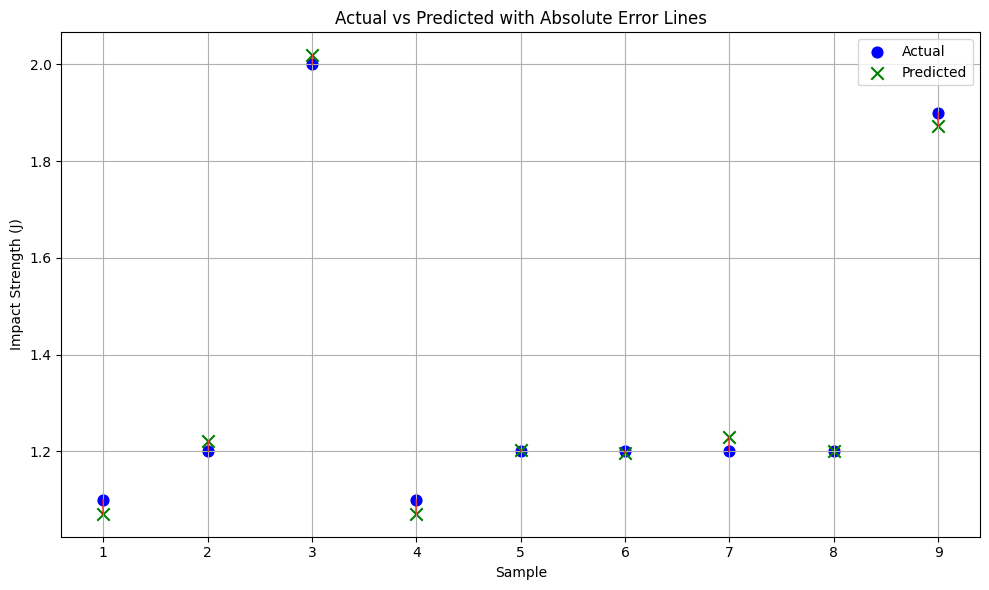


LOOCV MAE (Tuned Model): 0.018 J
LOOCV MSE (Tuned Model): 0.000 J²
LOOCV R² (Tuned Model): 0.996


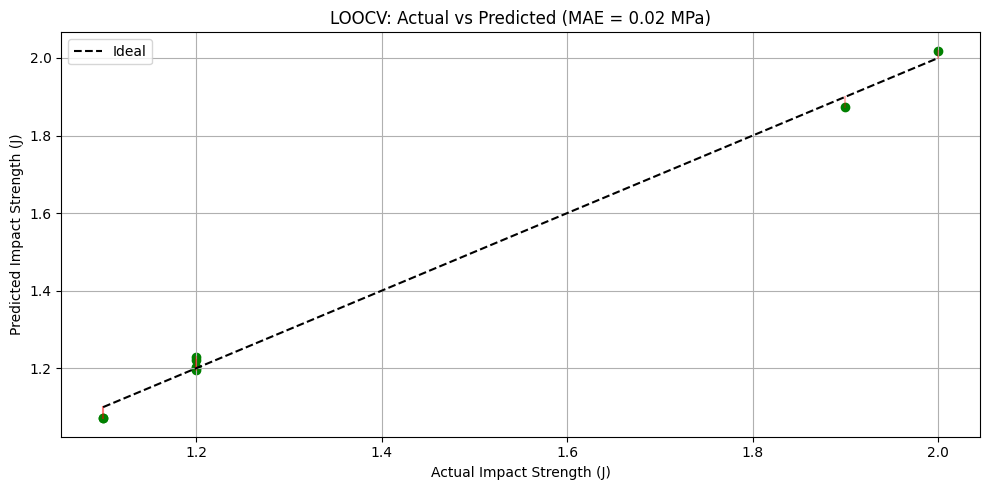

LOOCV Results:
   Actual  Predicted     Error
0     1.1   1.071072  0.028928
1     1.2   1.221403  0.021403
2     2.0   2.018692  0.018692
3     1.1   1.071234  0.028766
4     1.2   1.203664  0.003664
5     1.2   1.196825  0.003175
6     1.2   1.229013  0.029013
7     1.2   1.200576  0.000576
8     1.9   1.872380  0.027620

LOOCV MAE: 0.018 J
LOOCV R²: 0.996
LOOCV MSE: 0.000 J²

Grey Relational Analysis (GRA) Rankings:
SNR                  0.958851
Infill_x_Height      0.668216
Rater Angle (°)      0.617667
Layer Height (mm)    0.590521

DEAR (Data Envelopment Analysis-based Ranking) Results:
   Efficiency Score  DEAR Rank
2          1.694912        1.0
8          1.220077        2.0
1          0.538363        3.0
4          0.409420        4.0
5          0.243458        5.0
6          0.217274        6.0
7          0.156189        7.0
3          0.000000        8.5
0          0.000000        8.5


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and clean the dataset
df = pd.read_excel("DataSet/Impact.xlsx").dropna()

# Function to calculate Signal-to-Noise Ratio (SNR)
def calculate_snr(data):
    return -10 * np.log10(np.mean(1 / (data**2 + 1e-6)))

# Add SNR feature
df['SNR'] = df.groupby(
    ['Layer Height (mm)', 'Infill Percentage (%)', 'Outline Perimeter (n)', 'Rater Angle (°)']
)['Impact Strength (J)'].transform(calculate_snr)

# Create interaction feature
df['Infill_x_Height'] = df['Infill Percentage (%)'] * df['Layer Height (mm)']

# Define features and target
X = df[['Rater Angle (°)', 'Layer Height (mm)', 'Infill_x_Height', 'SNR']]
y = df['Impact Strength (J)']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SVR model and hyperparameter tuning
model = SVR()
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'epsilon': [0.01, 0.1, 0.5, 1], 
    'kernel': ['rbf', 'linear', 'poly'],
}

# Grid Search with LOOCV
loo = LeaveOneOut()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=loo,
                           scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled, y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best MAE (via GridSearchCV): {-best_score:.3f} MPa")

# Leave-One-Out Cross-Validation with best model
best_model = grid_search.best_estimator_
actual, predicted = [], []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)[0]

    actual.append(y_test.values[0])
    predicted.append(y_pred)

# Convert lists to numpy arrays
actual = np.array(actual)
predicted = np.array(predicted)
x_axis = np.arange(1, len(actual) + 1)

# Plot: Actual vs Predicted with Error Lines
plt.figure(figsize=(10, 6))
plt.scatter(x_axis, actual, label='Actual', color='blue', s=60)
plt.scatter(x_axis, predicted, label='Predicted', color='green', marker='x', s=80)
for i in range(len(x_axis)):
    plt.plot([x_axis[i], x_axis[i]], [actual[i], predicted[i]], 'r-', alpha=0.6)

plt.xlabel('Sample')
plt.ylabel('Impact Strength (J)')
plt.title('Actual vs Predicted with Absolute Error Lines')
plt.legend()
plt.grid(True)
plt.xticks(x_axis)
plt.tight_layout()
plt.savefig('Scatter_Error_Line.png', dpi=300)
plt.show()

# Metrics
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
r2 = r2_score(actual, predicted)

print(f"\nLOOCV MAE (Tuned Model): {mae:.3f} J")
print(f"LOOCV MSE (Tuned Model): {mse:.3f} J²")
print(f"LOOCV R² (Tuned Model): {r2:.3f}")

# Plot: Predicted vs Actual with Ideal Line
plt.figure(figsize=(10, 5))
plt.scatter(actual, predicted, c='green')
for i in range(len(actual)):
    plt.plot([actual[i], actual[i]], [actual[i], predicted[i]], 'r-', alpha=0.3)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--', label='Ideal')
plt.xlabel('Actual Impact Strength (J)')
plt.ylabel('Predicted Impact Strength (J)')
plt.title(f'LOOCV: Actual vs Predicted (MAE = {mae:.2f} MPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tabulate results
results = pd.DataFrame({
    'Actual': actual,
    'Predicted': predicted,
    'Error': np.abs(actual - predicted)
})

print("LOOCV Results:")
print(results)
print(f"\nLOOCV MAE: {results['Error'].mean():.3f} J")
print(f"LOOCV R²: {r2_score(actual, predicted):.3f}")
print(f"LOOCV MSE: {mean_squared_error(actual, predicted):.3f} J²")

# Grey Relational Analysis (GRA)
def perform_gra(X, y):
    data = X.copy()
    data['Target'] = y.values
    norm = (data - data.min()) / (data.max() - data.min())
    ref = norm['Target']
    eps = 1e-6
    delta = abs(norm.drop('Target', axis=1).sub(ref, axis=0))
    delta_min = delta.min().min()
    delta_max = delta.max().max()
    grc = (delta_min + 0.5 * delta_max) / (delta + 0.5 * delta_max + eps)
    grg = grc.mean()
    return grg.sort_values(ascending=False)

gra_result = perform_gra(X, y)
print("\nGrey Relational Analysis (GRA) Rankings:")
print(gra_result.to_string())

# DEAR (Data Envelopment Analysis-based Ranking)
def perform_dear(X, y):
    scaler_inputs = MinMaxScaler()
    scaler_output = MinMaxScaler()

    X_norm = scaler_inputs.fit_transform(X)
    y_norm = scaler_output.fit_transform(y.values.reshape(-1, 1))

    efficiency_scores = y_norm.flatten() / (X_norm.mean(axis=1) + 1e-6)

    dear_df = X.copy()
    dear_df['Tensile Strength'] = y.values
    dear_df['Efficiency Score'] = efficiency_scores
    dear_df['DEAR Rank'] = dear_df['Efficiency Score'].rank(ascending=False)

    return dear_df.sort_values('DEAR Rank')

dear_result = perform_dear(X, y)
print("\nDEAR (Data Envelopment Analysis-based Ranking) Results:")
print(dear_result[['Efficiency Score', 'DEAR Rank']])
